# 합성곱 신경망
### CIFAR 데이터셋 대신 Kaggle에서 다운받은 One Piece image classifier을 사용했습니다.
### 데이터셋 다운로드 링크 : https://www.kaggle.com/datasets/ibrahimserouis99/one-piece-image-classifier

### 변경점
- 새로운 데이터를 사용하여 10개 class를 분류해보았습니다.
- Tensorflow Callback을 이용하여 best model을 저장하고, 학습이 더이상 진행되지 않을 경우 학습을 종료하도록 하였습니다.

## 1. 데이터 준비

>### Data Info.
>#### Train Set : 5226 
>#### Validation Set : 1306 
>#### Classes : 10
>* Ace
>* Brook
>* Chopper
>* Franky
>* Luffy
>* Nami
>* Robin
>* Shanks
>* Usopp
>* Zoro

In [1]:
import numpy as np
from tensorflow.keras import layers, models, optimizers, utils, datasets
from utils import display
import os

In [2]:
NUM_CLASSES = 10

In [3]:
DATA_PATH = './Data'

In [4]:
os.listdir(DATA_PATH)

['Ace',
 'Brook',
 'Chopper',
 'Franky',
 'Luffy',
 'Nami',
 'Robin',
 'Shanks',
 'Usopp',
 'Zoro']

In [5]:
# 데이터셋 불러오기
from tensorflow.keras.utils import image_dataset_from_directory

dataset = image_dataset_from_directory(
    directory = os.path.join(DATA_PATH),
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256,256),
    shuffle=True,
    seed=100,
    validation_split=0.2,
    subset='training',
    interpolation='bilinear'
)

Found 6532 files belonging to 10 classes.
Using 5226 files for training.


In [6]:
# 검증 데이터셋
val_dataset = image_dataset_from_directory(
    directory = os.path.join(DATA_PATH),
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=1,
    image_size=(256,256),
    shuffle=True,
    seed=100,
    validation_split=0.2,
    subset='validation',
    interpolation='bilinear'
)

Found 6532 files belonging to 10 classes.
Using 1306 files for validation.


['Ace', 'Brook', 'Chopper', 'Franky', 'Luffy', 'Nami', 'Robin', 'Shanks', 'Usopp', 'Zoro']
(32, 256, 256, 3) (32, 10)
tf.Tensor(
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0.

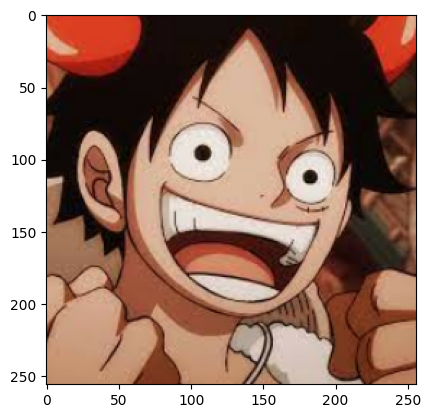

In [7]:
from matplotlib import pyplot as plt

# 클래스명 확인
print(dataset.class_names)
# 샘플 가져와보기
for data, label in dataset.take(1):
  print(data.shape, label.shape)
  print(label)
  plt.imshow(data[13].numpy().astype(np.uint8))

## 2. 전처리 (정규화)

In [8]:
# 범위 [0,255]에서 [0.,1.]로 정규화
def normalize_image(x, y):
  return x / 255.0, y

# 모든 데이터에 적용
dataset = dataset.map(normalize_image)

In [9]:
# 검증 데이터셋에도 적용
val_dataset = val_dataset.map(normalize_image)

In [10]:
# 확인
for data, label in dataset.take(1):
  data_numpy = data.numpy()
  print(np.min(data_numpy), np.max(data_numpy))

0.0 1.0


## 3. 모델 구성

In [24]:
input_layer = layers.Input((256, 256, 3))

x = layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same")(
    input_layer
)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(filters=32, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.GlobalMaxPooling2D()(x)

x = layers.Dense(64)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(rate=0.2)(x)

x = layers.Dense(NUM_CLASSES)(x)
output_layer = layers.Activation("softmax")(x)

model = models.Model(input_layer, output_layer)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
batch_normalization_5 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_6 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 128, 128, 32)      0   

In [25]:
import tensorflow as tf

# Early stopping (학습 조기 종료)
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=5,
    verbose=1, 
    mode='min',
    restore_best_weights=True
)

# Best model save (모델 저장)
save_model = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_weights.hdf5',
    save_best_only=True,
    monitor='val_loss',
    verbose=1,
    mode='min'
)

cb = [early_stop, save_model]

In [26]:
opt = optimizers.Adam(learning_rate=0.0001)
model.compile(
    loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"]
)

## 4. 모델 훈련

In [27]:
model.fit(
    dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=cb
)

Epoch 1/100
164/164 [==============================] - 12s 66ms/step - loss: 2.2981 - accuracy: 0.2093 - val_loss: 2.8667 - val_accuracy: 0.1248

Epoch 00001: val_loss improved from inf to 2.86669, saving model to best_weights.hdf5
Epoch 2/100
164/164 [==============================] - 11s 67ms/step - loss: 1.9396 - accuracy: 0.3274 - val_loss: 2.4337 - val_accuracy: 0.1815

Epoch 00002: val_loss improved from 2.86669 to 2.43367, saving model to best_weights.hdf5
Epoch 3/100
164/164 [==============================] - 11s 67ms/step - loss: 1.7713 - accuracy: 0.4015 - val_loss: 1.8792 - val_accuracy: 0.3622

Epoch 00003: val_loss improved from 2.43367 to 1.87923, saving model to best_weights.hdf5
Epoch 4/100
164/164 [==============================] - 11s 66ms/step - loss: 1.6301 - accuracy: 0.4550 - val_loss: 1.6432 - val_accuracy: 0.4648

Epoch 00004: val_loss improved from 1.87923 to 1.64322, saving model to best_weights.hdf5
Epoch 5/100
164/164 [==============================] - 11s 6

KeyboardInterrupt: 

## 5. 평가

In [28]:
model = tf.keras.models.load_model('best_weights.hdf5')

In [29]:
model.evaluate(val_dataset)

1306/1306 [==============================] - 4s 3ms/step - loss: 1.1271 - accuracy: 0.6401


[1.1271368265151978, 0.6401225328445435]

In [30]:
x_test = []
y_test = []
for data in val_dataset:
    x = data[0].numpy()
    y = data[1].numpy()
    x_test.append(x)
    y_test.append(y)

In [31]:
x_test = np.concatenate(x_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

In [32]:
CLASSES = np.array(['Ace','Brook','Chopper','Franky','Luffy','Nami','Robin','Shanks','Usopp','Zoro'])

preds = model.predict(val_dataset)
preds_single = CLASSES[np.argmax(preds, axis=-1)]
actual_single = CLASSES[np.argmax(y_test, axis=-1)]

In [33]:
preds_single

array(['Luffy', 'Luffy', 'Robin', ..., 'Chopper', 'Zoro', 'Franky'],
      dtype='<U7')

In [34]:
actual_single

array(['Franky', 'Luffy', 'Shanks', ..., 'Chopper', 'Usopp', 'Robin'],
      dtype='<U7')

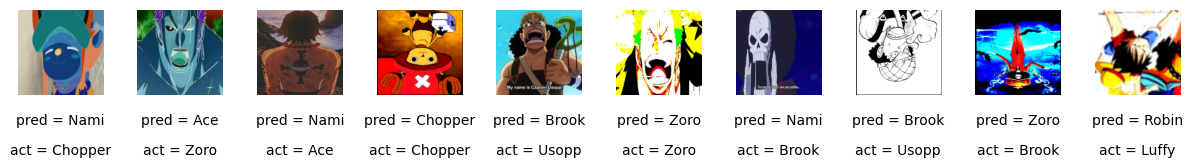

In [35]:
n_to_show = 10
indices = np.random.choice(range(len(x_test)), n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = x_test[idx]
    ax = fig.add_subplot(1, n_to_show, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        "pred = " + str(preds_single[idx]),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.text(
        0.5,
        -0.7,
        "act = " + str(actual_single[idx]),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(img)

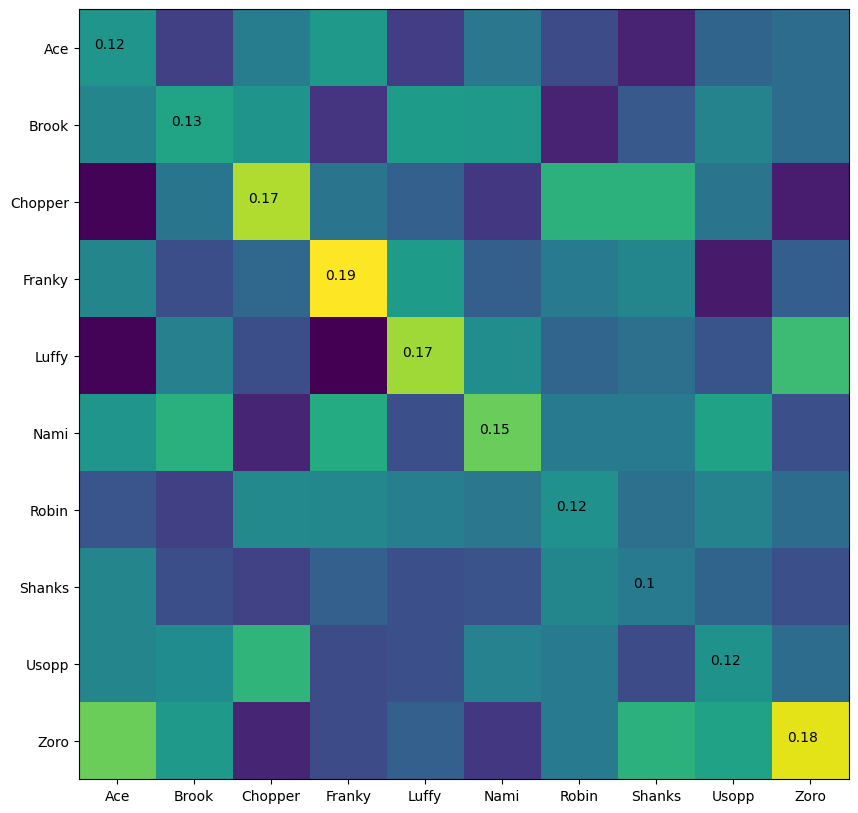

In [36]:
# 혼잡행렬 확인
from sklearn.metrics import confusion_matrix

con_matrix = confusion_matrix(y_true=np.argmax(y_test, axis=-1), y_pred=np.argmax(preds, axis=-1), normalize='pred')

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(con_matrix)
ax.set_xticks(np.arange(len(CLASSES)))
ax.set_xticklabels(CLASSES)
ax.set_yticks(np.arange(len(CLASSES)))
ax.set_yticklabels(CLASSES)
for i in range(len(CLASSES)):
  ax.text(-0.3+i,i, str(round(con_matrix[i,i],2)),fontsize=10, color='k')